In [25]:
%pip install pycocotools
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Object Detection

Object Detection is one of the most useful applications of CNN and other models. It is used to monitor security cameras, analyse traffic etc. This Jupyter Notebook explores single image inference using different models.

There are two types of Object Detection: One Stage and Two Stage.

Two stage detectors first propose object regions and then refine them based on whether it thinks it's background noise or actually an object. eg. RCNN and it's variants

One stage detectors skip the proposal stage and just draw boxes based on features draw out from a CNN architecture. eg. YOLO

In [26]:
#imports
import torch
import torchvision
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from ultralytics import YOLO
from pycocotools.coco import COCO
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from pycocotools.cocoeval import COCOeval
from skimage.feature import hog
from skimage import color
from sklearn.svm import SVC
import joblib
from sklearn.metrics import average_precision_score
import os


These models are all pretrained because training these models on a dataset as large as COCO takes huge amounts of CPU/GPU power.

In [27]:
#you can choose any image id for inference from instances_val2017.json
coco = COCO("coco2017/annotations/instances_val2017.json")
image_id = 452321
image_info = coco.loadImgs(image_id)[0]
image_path = f"coco2017/val2017/{image_info['file_name']}"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


Let's take a look at the image we're going to try and detect objects in.

Image shape after loading and converting to RGB: (480, 640, 3)


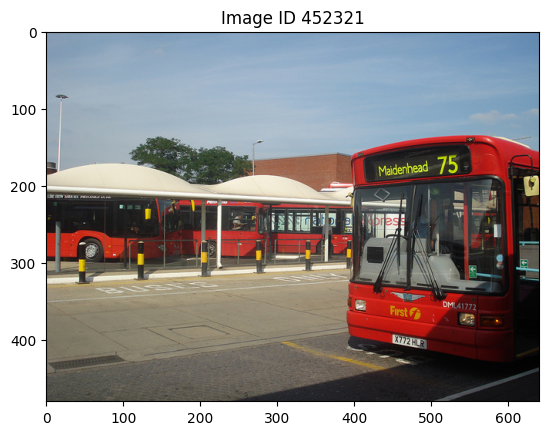

In [28]:
print(f"Image shape after loading and converting to RGB: {image.shape}")

plt.imshow(image)
plt.title(f"Image ID {image_id}")
plt.show()

Resizing and Upscaling

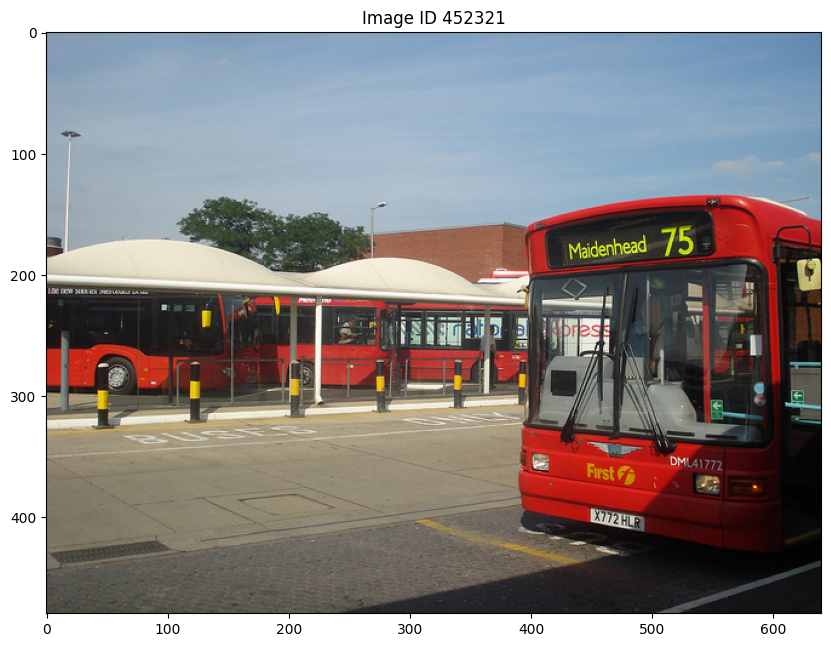

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))  # Set a reasonable size for the figure
ax.imshow(image)
ax.set_title(f"Image ID {image_id}")
plt.show()

Conversion to Tensor

In [30]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

image_tensor = transform(image).unsqueeze(0)

Loading RCNN models

In [31]:
faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()

rcnn = maskrcnn_resnet50_fpn(pretrained=True)
rcnn.eval()

c:\Users\scxrp\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\scxrp\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\scxrp\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `w

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Loading YOLO models

In [80]:
yolov5 = YOLO("yolov5x.pt")
yolov11 = YOLO("yolo11x.pt")

PRO TIP  Replace 'model=yolov5x.pt' with new 'model=yolov5xu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



There is no implementation of DPM or HOGSVM available because they simply cannot detect objects as well as the newer models and require a lot longer to train.

This HOGSVM model that we've loaded is trained on only 1000 images of COCO2017. It is not functional because of small training dataset. However, if you want to train it you can refer to the DPM implementation file and change the training dataset to the comeplete COCO2017.

c:\Users\scxrp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.5.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\scxrp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


loading annotations into memory...
Done (t=1.69s)
creating index...
index created!
Detected object: [0, 0, 64, 128], Class: person
Detected object: [16, 0, 80, 128], Class: person
Detected object: [32, 0, 96, 128], Class: person
Detected object: [48, 0, 112, 128], Class: person
Detected object: [64, 0, 128, 128], Class: person
Detected object: [80, 0, 144, 128], Class: chair
Detected object: [96, 0, 160, 128], Class: person
Detected object: [112, 0, 176, 128], Class: person
Detected object: [128, 0, 192, 128], Class: person
Detected object: [144, 0, 208, 128], Class: person
Detected object: [160, 0, 224, 128], Class: person
Detected object: [176, 0, 240, 128], Class: person
Detected object: [192, 0, 256, 128], Class: person
Detected object: [208, 0, 272, 128], Class: person
Detected object: [224, 0, 288, 128], Class: person
Detected object: [240, 0, 304, 128], Class: person
Detected object: [256, 0, 320, 128], Class: person
Detected object: [272, 0, 336, 128], Class: person
Detected ob

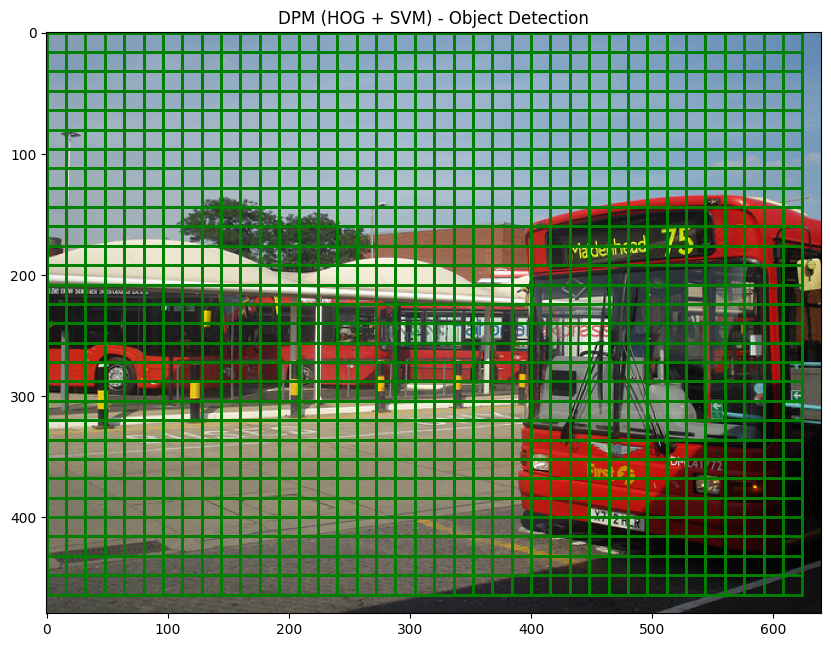

In [ ]:
#check Week3_ObjectDetection_DPMImplementation for implementation
svm, label_encoder = joblib.load("hog_svm_coco.pkl")

coco = COCO("coco2017/annotations/instances_val2017.json")
image_id = 452321
image_info = coco.loadImgs(image_id)[0]
image_path = f"coco2017/val2017/{image_info['file_name']}"

#convert image to rgb
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image at {image_path} could not be loaded. Check the path.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#sliding window for image processing
WINDOW_SIZE = (64, 128)
STEP_SIZE = 16

def sliding_window(image, step_size=STEP_SIZE, window_size=WINDOW_SIZE):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y+window_size[1], x:x+window_size[0]])

#detect objects
def detect_objects(image):
    bounding_boxes = []

    for (x, y, window) in sliding_window(image):
        gray_window = cv2.cvtColor(window, cv2.COLOR_RGB2GRAY)  #hog uses intensity so colour is useless. we use grayscale to keep intensity without losing information
        
        features = hog(gray_window, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        
        prediction = svm.predict([features])[0]
        
        if prediction != 0:
            bbox = [x, y, x + WINDOW_SIZE[0], y + WINDOW_SIZE[1]]
            bounding_boxes.append(bbox)
            print(f"Detected object: {bbox}, Class: {label_encoder.inverse_transform([prediction])[0]}")

    return bounding_boxes

bounding_boxes = detect_objects(image)

print("\nFinal bounding boxes:", bounding_boxes)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

for box in bounding_boxes:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.title("DPM (HOG + SVM) - Object Detection")
plt.show()

So, clearly HOG + SVM (nor DPM) can't understand what's happening here. It forces a prediction for every sliding window increment. This means it's just guessing at random and picking whatever pre-defined class has the highest weightage(in this example, person).

We can do a single image inference on all on the four models that we've lined up. This means that we can dedicate more time to a single image rather than a video where the speed also matters a lot.

In [83]:
with torch.no_grad():
    predictions_rcnn = faster_rcnn(image_tensor)
    predictions_mask_rcnn = rcnn(image_tensor)

yolo_results_v5 = yolov5(image)
yolo_results_v11 = yolov11(image)


0: 480x640 1 person, 2 buss, 1011.9ms
Speed: 0.0ms preprocess, 1011.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 buss, 913.1ms
Speed: 2.0ms preprocess, 913.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


In [69]:
print(predictions_rcnn)
print(predictions_mask_rcnn)

[{'boxes': tensor([[383.0958, 134.0013, 640.0000, 432.6905],
        [  5.0826, 180.3843, 395.4779, 303.6631],
        [241.0229, 241.9420, 257.7179, 258.9620],
        [388.5600, 275.4382, 397.6609, 309.3232],
        [351.5889, 244.0071, 375.6282, 297.9787],
        [499.0497, 247.0450, 509.9723, 287.2945],
        [  4.7978, 168.4728, 404.7530, 310.9825],
        [265.2124, 238.7694, 273.0283, 259.0248],
        [147.0541, 209.8372, 399.3047, 304.1311],
        [502.6278, 254.9328, 510.9718, 287.7406],
        [497.9961, 237.5004, 517.3899, 288.1274],
        [335.9619, 279.8868, 344.9481, 310.3497],
        [245.2815, 244.0222, 263.5392, 259.6913],
        [ 41.3648, 285.9621,  53.2946, 319.1614],
        [243.6444, 238.9569, 253.8733, 255.1975],
        [257.4906, 239.7788, 273.0280, 259.6921],
        [141.0025, 208.9618, 402.0609, 304.7458]]), 'labels': tensor([ 6,  6,  1,  1,  1,  1,  7,  1,  6,  1,  1, 11,  1, 11,  1,  1,  7]), 'scores': tensor([0.9994, 0.9605, 0.8729, 0.2980,

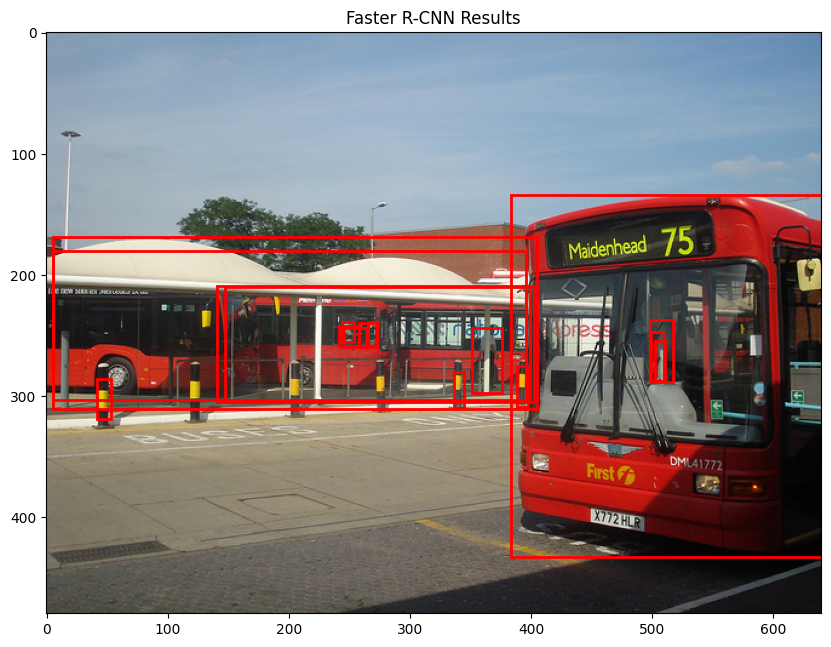

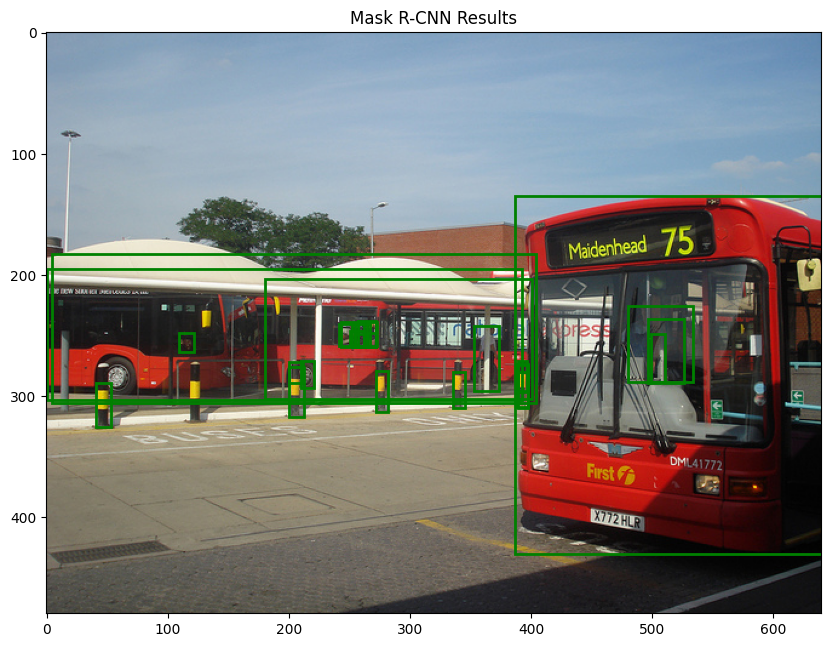

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
for box in predictions_rcnn[0]['boxes']:
    x_min, y_min, x_max, y_max = box.cpu().numpy()
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.title(f"Faster R-CNN Results")
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
for box in predictions_mask_rcnn[0]['boxes']:
    x_min, y_min, x_max, y_max = box.cpu().numpy()
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
plt.title(f"Mask R-CNN Results")
plt.show()

Faster RCNN uses a Region Proposal Network instead of just Selective Search to choose where the objects are. It generates potential object regions using sliding windows. ROI pooling is used to extract the feature maps for each region and this is what is passed to the FC layer.

Mask RCNN adds a layer on top of that. Faster RCNN will only tell you that there is an object in this box. However, it doesn't say much about the object's boundaries. This is what Mask RCNN tries to do. It adds segmentation to the pixel-wise. This way, it tries to outline the exact shape of the object. This is especially important with overlapping/3D objects.

In [72]:
yolo_v5_boxes = yolo_results_v5[0].boxes
yolo_v5_df = pd.DataFrame(yolo_v5_boxes.xywh.cpu().numpy(), columns=["x_center", "y_center", "width", "height"])

yolo_v11_boxes = yolo_results_v11[0].boxes
yolo_v11_df = pd.DataFrame(yolo_v11_boxes.xywh.cpu().numpy(), columns=["x_center", "y_center", "width", "height"])

print("YOLOv5 Results (xywh):")
print(yolo_v5_df)

print("\nYOLOv11 Results (xywh):")
print(yolo_v11_df)

YOLOv5 Results (xywh):
     x_center    y_center       width      height
0  514.321411  283.526886  250.434540  297.461426
1  199.380615  236.295776  398.071289  130.164124
2  365.544098  268.889832   16.619446   53.602173

YOLOv11 Results (xywh):
     x_center    y_center       width      height
0  513.971558  283.864929  250.963379  297.226196
1  198.735535  236.357254  396.289795  129.427826


Gathering and Visualising the YOLO boxes

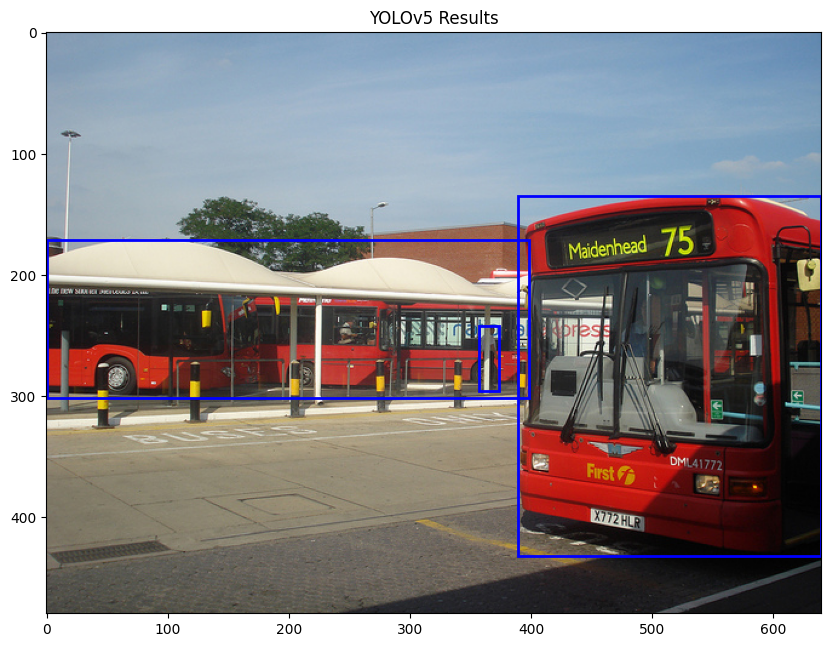

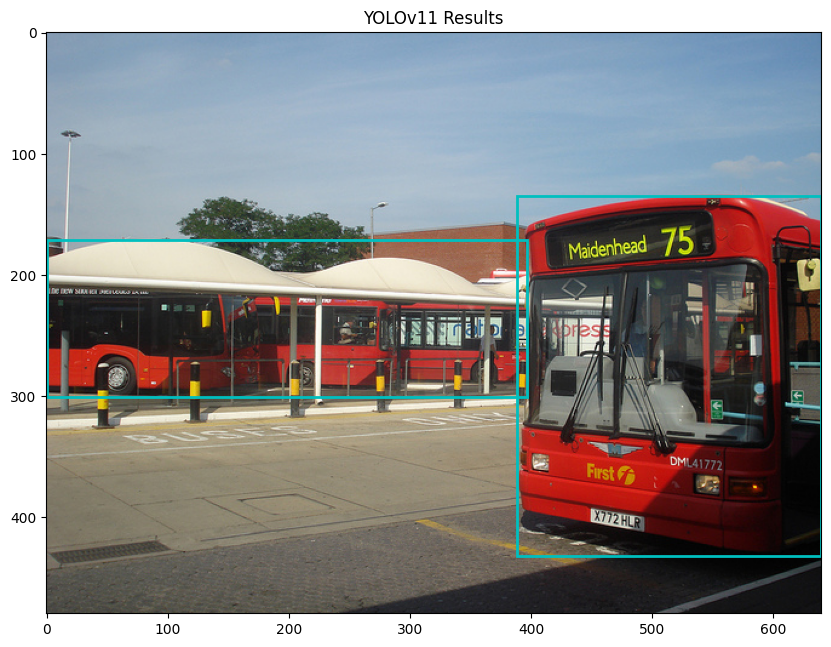

In [73]:
ig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

for box in yolo_results_v5[0].boxes.xywh:
    x_center, y_center, width, height = box.cpu().numpy()
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

plt.title(f"YOLOv5 Results")
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

for box in yolo_results_v11[0].boxes.xywh
    x_center, y_center, width, height = box.cpu().numpy()
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='c', facecolor='none')
    ax.add_patch(rect)

plt.title(f"YOLOv11 Results")
plt.show()


YOLO is a single stage object detector. It is very fast and that is why it's mostly used for object detection in video.
It removes low confidence boxes and only keeps the high confidence boxes. It also struggles with overlapping and smaller objects. However, if you want it to detect smaller objects, you just need better photo/video quality since YOLO works on a grid basis.

The differences between YOLO v5 and YOLO v11 are more to do with the improvements in AI research in the 4 years between their respective releases. However, YOLOv11 does incorporate Multi-head attention and uses a new C3K2 backbone.

In [74]:
#make xyxy from xywh

def xywh_to_xyxy(df):
    xyxy_boxes = []
    for _, row in df.iterrows():
        x_c, y_c, w, h = row["x_center"], row["y_center"], row["width"], row["height"]
        x_min = x_c - (w / 2)
        y_min = y_c - (h / 2)
        x_max = x_c + (w / 2)
        y_max = y_c + (h / 2)
        xyxy_boxes.append([x_min, y_min, x_max, y_max])
    return np.array(xyxy_boxes)

yolo_v5_xyxy = xywh_to_xyxy(yolo_v5_df)
yolo_v11_xyxy = xywh_to_xyxy(yolo_v11_df)

print("Converted YOLOv5 Boxes (xyxy):\n", yolo_v5_xyxy)
print("\nConverted YOLOv11 Boxes (xyxy):\n", yolo_v11_xyxy)


Converted YOLOv5 Boxes (xyxy):
 [[      389.1       134.8      639.54      432.26]
 [    0.34497      171.21      398.42      301.38]
 [     357.23      242.09      373.85      295.69]]

Converted YOLOv11 Boxes (xyxy):
 [[     388.49      135.25      639.45      432.48]
 [    0.59064      171.64      396.88      301.07]]


We convert the width and height measurements of the box that YOLO uses to the pixel values in xyxy

In [75]:
coco_gt = COCO("coco2017/annotations/instances_val2017.json")

def get_ground_truth(image_id):
    ann_ids = coco_gt.getAnnIds(imgIds=image_id)
    annotations = coco_gt.loadAnns(ann_ids)
    
    gt_boxes = []
    for ann in annotations:
        x_min, y_min, w, h = ann['bbox']
        x_max, y_max = x_min + w, y_min + h
        gt_boxes.append([x_min, y_min, x_max, y_max])
    
    return np.array(gt_boxes)

image_id = 452321
ground_truths = get_ground_truth(image_id)

print(ground_truths)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
[[     389.04      135.78         640      435.47]
 [       2.16      209.26      185.53      296.63]
 [     287.07      224.25      397.66       289.7]
 [     172.44      218.52      291.08      293.52]]


Since we have access to the dataset, we can just obtain the ground truths instead of manually deciding it.

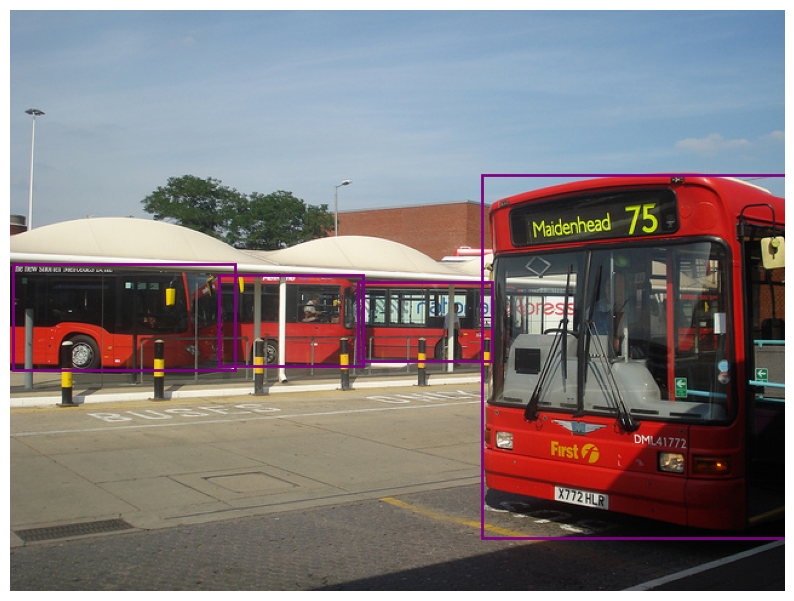

In [85]:
def plot_bounding_boxes(image, ground_truths):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for box in ground_truths:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          linewidth=2, edgecolor='purple', facecolor='none'))
    plt.axis('off')
    plt.show()

plot_bounding_boxes(image, ground_truths)

So, there are actually 4 buses as we can clearly see. But most of the models had trouble with determining the difference between the 3 buses at the back.

## IoU & mAP calculations

IoU (Intersection over Union) measures the overlap between the ground truth and the predicted box.

It's the ratio of the Area of Intersection and the Area of Union. We compare it to either 0.5 or 0.75. It is essentially the lenience we're measuring the inference by.

This is used as a threshold for True Positives. So, if the IoU of two boxes is above 0.5, it will be considered a True Positive. So a 0.6 IoU would be TP for 0.5 but not for 0.75.

mAP (mean Average Precision) summarises the precision and recall of the inference over different thresholds. You calculate the average precision (AP) for each class individually and then average these values across all classes. This essentially gives you the model performance.

In [76]:
def calculate_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2
    
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)
    
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)
    
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area != 0 else 0

def calculate_map(predictions, ground_truths):
    y_true = []
    y_scores = []

    matched_gt = set()

    for pred in predictions:
        best_iou = 0
        best_gt_idx = -1

        for idx, gt_box in enumerate(ground_truths):
            iou = calculate_iou(pred, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx

        if best_iou >= 0.5:
            y_true.append(1)
            matched_gt.add(best_gt_idx)
        else:
            y_true.append(0)

        y_scores.append(best_iou)

    num_false_negatives = len(ground_truths) - len(matched_gt)
    y_true.extend([1] * num_false_negatives)
    y_scores.extend([0] * num_false_negatives)

    return average_precision_score(y_true, y_scores)

#we need different evaluation functions because they're built on different frameworks

def evaluate_faster_rcnn(predictions, ground_truths):
    iou_values = []
    iou_values_75 = []
    for i in range(len(predictions[0]['boxes'])):
        pred_box = predictions[0]['boxes'][i].cpu().numpy()
        for j in range(len(ground_truths)):
            gt_box = ground_truths[j]
            iou = calculate_iou(pred_box, gt_box)
            iou_values.append(iou)
            if iou >= 0.75:
                iou_values_75.append(iou)
    return np.mean(iou_values), np.mean(iou_values_75)

def evaluate_yolo(yolo_xyxy_boxes, ground_truths):
    if not len(yolo_xyxy_boxes):
        print("Warning: No valid YOLO predictions found.")
        return 0, 0, 0

    mAP = calculate_map(yolo_xyxy_boxes, ground_truths)

    iou_values = []
    iou_values_75 = []
    for pred in yolo_xyxy_boxes:
        best_iou = 0
        for gt_box in ground_truths:
            iou = calculate_iou(pred, gt_box)
            best_iou = max(best_iou, iou)
            if iou >= 0.75:
                iou_values_75.append(iou)
        iou_values.append(best_iou)

    avg_iou = np.mean(iou_values) if iou_values else 0
    avg_iou_75 = np.mean(iou_values_75) if iou_values_75 else 0
    return mAP, avg_iou, avg_iou_75

'''
def evaluate_dpm(dpm_predictions, ground_truths):
    if not isinstance(dpm_predictions, list):
        dpm_predictions = [dpm_predictions]

    iou_values = []
    iou_values_75 = []
    for pred_box in dpm_predictions:
        if len(pred_box) != 4:
            print(f"Skipping DPM box with unexpected format: {pred_box}")
            continue

        for gt_box in ground_truths:
            iou = calculate_iou(pred_box, gt_box)
            iou_values.append(iou)
            if iou >= 0.75:
                iou_values_75.append(iou)

    if not iou_values:
        print("Warning: No valid DPM predictions found.")
        return 0, 0

    return np.mean(iou_values), np.mean(iou_values_75)
'''


In [77]:
# 1. Faster R-CNN
faster_rcnn_iou, faster_rcnn_iou_75 = evaluate_faster_rcnn(predictions_rcnn, ground_truths)

# 2. Mask R-CNN
mask_rcnn_iou, mask_rcnn_iou_75 = evaluate_faster_rcnn(predictions_mask_rcnn, ground_truths)

# 3. YOLOv5
yolov5_map, yolov5_iou, yolov5_iou_75 = evaluate_yolo(yolo_v5_xyxy, ground_truths)

# 4. YOLOv11
yolov11_map, yolov11_iou, yolov11_iou_75 = evaluate_yolo(yolo_v11_xyxy, ground_truths)


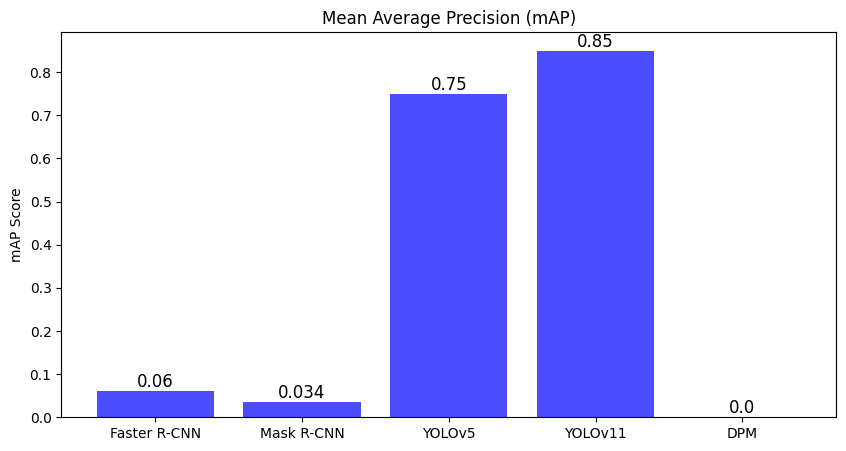

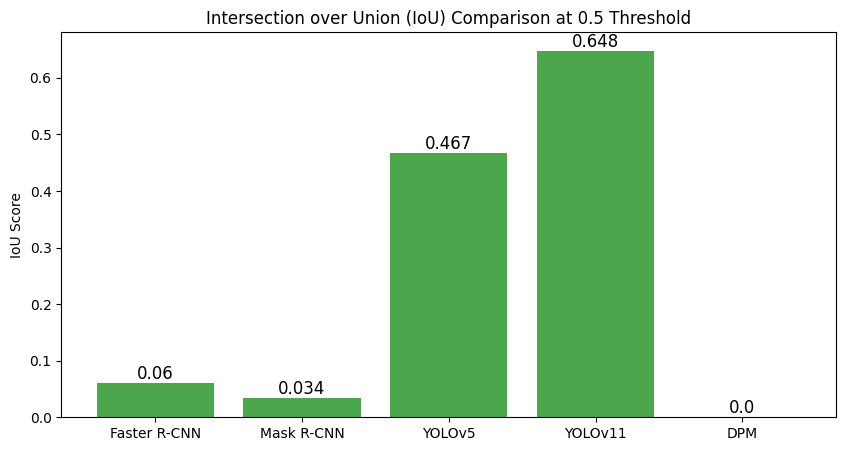

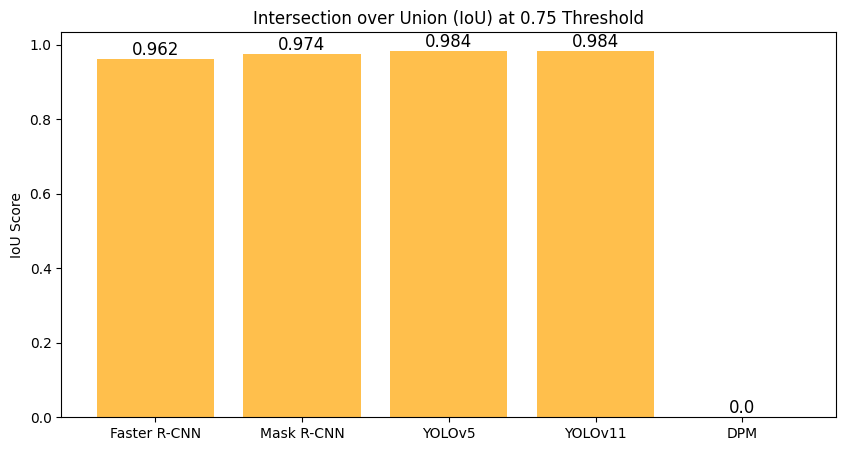

In [ ]:
import matplotlib.pyplot as plt

models = ['Faster R-CNN', 'Mask R-CNN', 'YOLOv5', 'YOLOv11', 'DPM']
map_scores = [faster_rcnn_iou, mask_rcnn_iou, yolov5_map, yolov11_map, 0]
iou_scores = [faster_rcnn_iou, mask_rcnn_iou, yolov5_iou, yolov11_iou, 0]
iou_75_scores = [faster_rcnn_iou_75, mask_rcnn_iou_75, yolov5_iou_75, yolov11_iou_75, 0]  # IoU with threshold 0.75

plt.figure(figsize=(10, 5))
bars = plt.bar(models, map_scores, color='blue', alpha=0.7, label='mAP')
plt.ylabel('mAP Score')
plt.title('Mean Average Precision (mAP)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom', fontsize=12)

plt.show()

plt.figure(figsize=(10, 5))
bars = plt.bar(models, iou_scores, color='green', alpha=0.7, label='IoU')
plt.ylabel('IoU Score')
plt.title('Intersection over Union (IoU) Comparison at 0.5 Threshold')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom', fontsize=12)

plt.show()

plt.figure(figsize=(10, 5))
bars = plt.bar(models, iou_75_scores, color='orange', alpha=0.7, label='IoU at 0.75 Threshold')
plt.ylabel('IoU Score')
plt.title('Intersection over Union (IoU) at 0.75 Threshold')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom', fontsize=12)

plt.show()


So the takeaway from this is that YOLO is much faster and provides closer to the ground truths since it's not fussed with making sure all the low confidence are also detected.

RCNN, however, struggles with the metrics since it predicted tons of small phantom objects that don't exist and thereby crippling it's low threshold IoU score. However, if we filter those away, it still very respectable IoU score